In [188]:
%load_ext autoreload
%autoreload 2
import alf.io as ioalf
from brainbox.population.cca import *
import matplotlib.pylab as plt

BIN_SIZE = 0.025  # seconds
SMOOTH_SIZE = 0.025  # seconds; standard deviation of gaussian kernel
PCA_DIMS = 20
CCA_DIMS = PCA_DIMS
N_SPLITS = 5
RNG_SEED = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# get the data from flatiron
# subject = 'ZM_1735'
# date = '2019-08-01'
# number = 1

# one = ONE()
# eid = one.search(subject=subject, date=date, number=number)
# D = one.load(eid[0], download_only=True)
# session_path = Path(D.local_path[0]).parent
# session_path = "/home/hmvergara/Downloads/FlatIron/mnt/s0/Data/Subjects/ZM_1735/2019-08-01/001/alf/"
session_path = "/home/hmvergara/Downloads/FlatIron/KS005/2019-08-29/001/alf/"
spikes = ioalf.load_object(session_path, 'spikes')
clusters = ioalf.load_object(session_path, 'clusters')
# channels = ioalf.load_object(session_path, 'channels')
trials = ioalf.load_object(session_path, '_ibl_trials')

2019-09-06 15:31:35.626 WARNING  [io.py:205] Inconsistent dimensions for object:clusters
(1235,),    amps
(1235, 1),    brainAcronyms
(1235,),    depths
(1235, 3),    mlapdv
(1235,),    peakChannel
(1235,),    probes
(1235, 82, 748),    templateWaveforms
(1235, 1235),    waveformDuration


In [10]:
# bin spikes and get trial IDs associated with them
binned_spikes, binned_trialIDs, _ = bin_spikes_trials(spikes, trials, T_BIN=BIN_SIZE)

# extract 2 populations
data = [binned_spikes[:, :100], binned_spikes[:, 100:200]]

# preprocess data
for i, pop in enumerate(data):
    data[i] = preprocess(pop, n_pcs=PCA_DIMS, smoothing_sd=SMOOTH_SIZE)

# split trials
idxs_trial = split_trials(np.unique(binned_trialIDs), n_splits=N_SPLITS, rng_seed=RNG_SEED)
# get train/test indices into spike arrays
idxs_time = split_timepoints(binned_trialIDs, idxs_trial)

# fit cca
ccas = [None for _ in range(N_SPLITS)]
dtype = 'train'
for k, idxs in enumerate(idxs_time):
    ccas[k] = fit_cca(data[0][idxs[dtype], :], data[1][idxs[dtype], :], n_cca_dims=CCA_DIMS)
# find cca correlations
dtype = 'test'
corrs = [None for _ in range(N_SPLITS)]
for k, idxs in enumerate(idxs_time):
    corrs[k] = get_correlations(ccas[k], data[0][idxs[dtype], :], data[1][idxs[dtype], :])

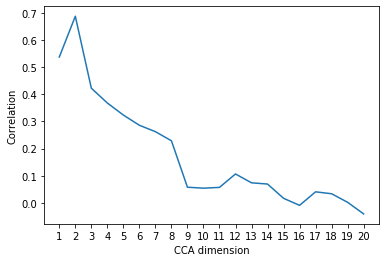

In [13]:
plot_correlations(corrs[0])

In [16]:
## Generate a matrix of correlations (biggest correlation found) between all pairwise areas
# bin spikes and get trial IDs associated with them
binned_spikes, binned_trialIDs, bin_times = bin_spikes_trials(spikes, trials, T_BIN=BIN_SIZE)

In [4]:
# Define areas
brain_areas = np.unique(clusters.brainAcronyms)
# [subset for testing] DELETE
#brain_areas = brain_areas[1:4]

In [5]:
# Split/create populations
# bin_spikes_trials does not return info for innactive clusters
active_clusters = np.unique(spikes['clusters'])
split_binned_spikes = split_by_area(binned_spikes, clusters.brainAcronyms,
                                    active_clusters, brain_areas)

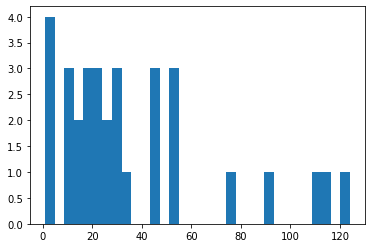

In [7]:
# plot a histogram of the number of neurons per region
clusters_per_brain_areas = [len(i.T) for i in split_binned_spikes]
plt.hist(clusters_per_brain_areas, bins=len(split_binned_spikes))
plt.show()

In [8]:
# select brain areas based on size of clusters and redo
cutoff = 60
brain_areas = brain_areas[np.array(clusters_per_brain_areas) > cutoff]
brain_areas

array(['APN', 'MRN', 'ProS', 'dhc', 'fp'], dtype=object)

In [9]:
# Split/create populations again
split_binned_spikes = split_by_area(binned_spikes, clusters.brainAcronyms,
                                    active_clusters, brain_areas)

In [10]:
# preprocess data
for i, pop in enumerate(split_binned_spikes):
    split_binned_spikes[i] = preprocess(pop, n_pcs=PCA_DIMS, smoothing_sd=SMOOTH_SIZE)

In [11]:
# split trials
idxs_trial = split_trials(np.unique(binned_trialIDs), n_splits=N_SPLITS, rng_seed=RNG_SEED)
# get train/test indices into spike arrays
idxs_time = split_timepoints(binned_trialIDs, idxs_trial)

In [18]:
# Create empty "matrix" to store cca objects
ccas_mat = [[None for _ in range(len(brain_areas))] for _ in range(len(brain_areas))]
# Create empty "matrix" to store correlations
corrs_mat = [[None for _ in range(len(brain_areas))] for _ in range(len(brain_areas))]

# For each pair of populations:
for i in range(len(brain_areas)):
    pop1 = split_binned_spikes[i]
    for j in range(len(brain_areas)):
        if j > i:
            pop2 = split_binned_spikes[j]
            # fit cca
            ccas = [None for _ in range(N_SPLITS)]
            dtype = 'train'
            for k, idxs in enumerate(idxs_time):
                ccas[k] = fit_cca(pop1[idxs[dtype], :], pop2[idxs[dtype], :], n_cca_dims=CCA_DIMS)
            # populate matrix
            ccas_mat[i][j] = ccas
            # find cca correlations
            dtype = 'test'
            corrs = [None for _ in range(N_SPLITS)]
            for k, idxs in enumerate(idxs_time):
                corrs[k] = get_correlations(ccas[k], pop1[idxs[dtype], :], pop2[idxs[dtype], :])
            # populate matrix
            corrs_mat[i][j] = corrs
            # print progress
            print("{} / {}".format(i, j))

0 / 1


In [23]:
# get things ready for plotting
means_list = [[None for _ in range(len(brain_areas))] for _ in range(len(brain_areas))]
serrs_list = [[None for _ in range(len(brain_areas))] for _ in range(len(brain_areas))]
for i in range(len(brain_areas)-1):
    for j in range(i+1, len(brain_areas)):
        corrs = corrs_mat[i][j]
        vals = np.stack(corrs, axis=1)
        means_list[j][i] = np.mean(vals, axis=1)
        serrs_list[j][i] = np.std(vals, axis=1) / np.sqrt(N_SPLITS)

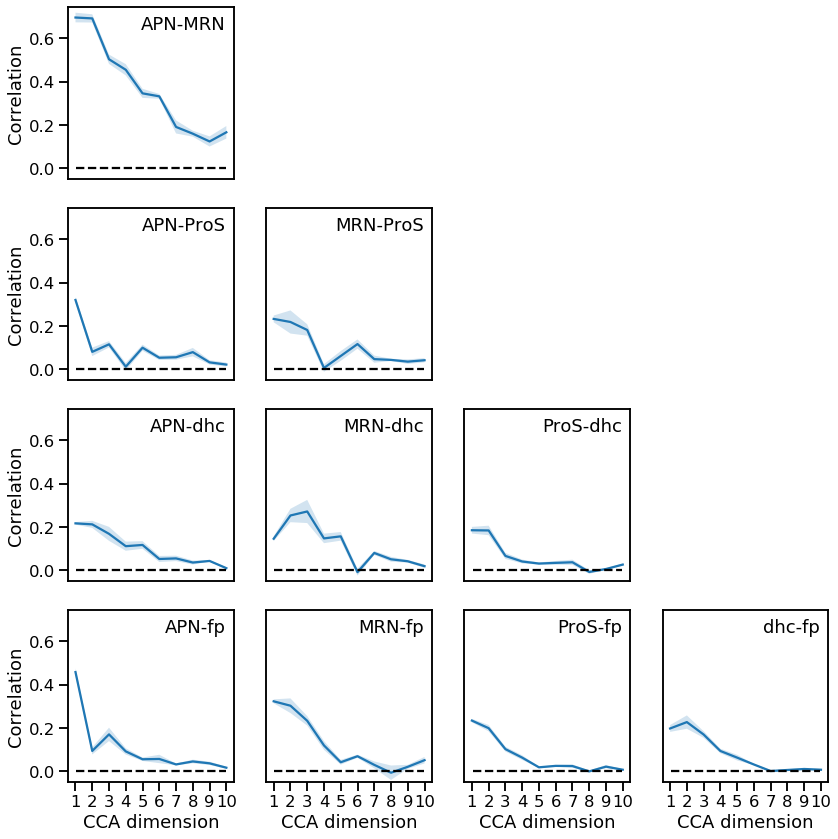

In [27]:
import seaborn as sns
sns.set_context('talk')
fig=plot_pairwise_correlations(means_list, serrs_list, n_dims=10, region_strs=brain_areas)

### <br><br> Make correlations specific to behavioural events

In [156]:
#wrapper of above
def correlations_to_event(sp_bn_sp, bn_tr):
    """
    Get the correlations structure
    :param sp_bn_sp: split_binned_spikes
    :param bn_tr: binned_trialIDs
    TODO: populate this
    """
    # split trials
    idxs_trial = split_trials(np.unique(bn_tr), n_splits=N_SPLITS, rng_seed=RNG_SEED)
    # get train/test indices into spike arrays
    idxs_time = split_timepoints(bn_tr, idxs_trial)


    # Create empty "matrix" to store cca objects
    ccas_mat = [[None for _ in range(len(sp_bn_sp))] for _ in range(len(sp_bn_sp))]
    # Create empty "matrix" to store correlations
    corrs_mat = [[None for _ in range(len(sp_bn_sp))] for _ in range(len(sp_bn_sp))]

    # For each pair of populations:
    for i in range(len(sp_bn_sp)):
        pop1 = sp_bn_sp[i]
        for j in range(len(sp_bn_sp)):
            if j > i:
                pop2 = sp_bn_sp[j]
                # fit cca
                ccas = [None for _ in range(N_SPLITS)]
                dtype = 'train'
                for k, idxs in enumerate(idxs_time):
                    ccas[k] = fit_cca(pop1[idxs[dtype], :], pop2[idxs[dtype], :], n_cca_dims=CCA_DIMS)
                # populate matrix
                ccas_mat[i][j] = ccas
                # find cca correlations
                dtype = 'test'
                corrs = [None for _ in range(N_SPLITS)]
                for k, idxs in enumerate(idxs_time):
                    corrs[k] = get_correlations(ccas[k], pop1[idxs[dtype], :], pop2[idxs[dtype], :])
                # populate matrix
                corrs_mat[i][j] = corrs
                # print progress
                print("{} / {}".format(i, j))
                
    return corrs_mat
            

In [157]:
trials.keys()

dict_keys(['choice', 'contrastLeft', 'contrastRight', 'feedbackType', 'feedback_times', 'goCueTrigger_times', 'goCue_times', 'intervals', 'intervalsBpod', 'itiDuration', 'probabilityLeft', 'response_times', 'rewardVolume', 'stimOn_times'])

In [158]:
brain_areas = np.array(['APN', 'MRN', 'ProS'])

In [159]:
binned_spikes, binned_trialIDs, bin_times = bin_spikes_trials(spikes, trials, T_BIN=BIN_SIZE)

In [174]:
active_clusters = np.unique(spikes['clusters'])
split_binned_spikes = split_by_area(binned_spikes, clusters.brainAcronyms,
                                    active_clusters, brain_areas)

In [175]:
# preprocess data
for i, pop in enumerate(split_binned_spikes):
    split_binned_spikes[i] = preprocess(pop, n_pcs=PCA_DIMS, smoothing_sd=SMOOTH_SIZE)

In [176]:
# define behavioural events
stimulus_onset = trials.stimOn_times
# from Olivier because of synchronization problems
response_times = trials.response_times + 12.489

behav_events_list = [stimulus_onset, response_times]
windows_list = [[0, 0.2], [-0.2, 2]]

In [178]:
corrs_mat_list = []
for j in range(len(behav_events_list)):
    # Select the indexes of the bins corresponding to a specific behavioral event
    event_bin_indexes = get_event_bin_indexes(behav_events_list[j], bin_times, windows_list[j])
    
    # select data related to the behavioral event
    split_binned_spikes_be = split_binned_spikes.copy()
    binned_trialIDs_be = binned_trialIDs.copy()
    for i, pop in enumerate(split_binned_spikes_be):
        split_binned_spikes_be[i] = pop[event_bin_indexes,:]
    binned_trialIDs_be = binned_trialIDs_be[event_bin_indexes]
    print(j)
    # get the correlation matrix
    corrs_mat_list.append(correlations_to_event(split_binned_spikes_be, binned_trialIDs_be))
    

0
0 / 1
0 / 2
1 / 2
1
0 / 1
0 / 2
1 / 2


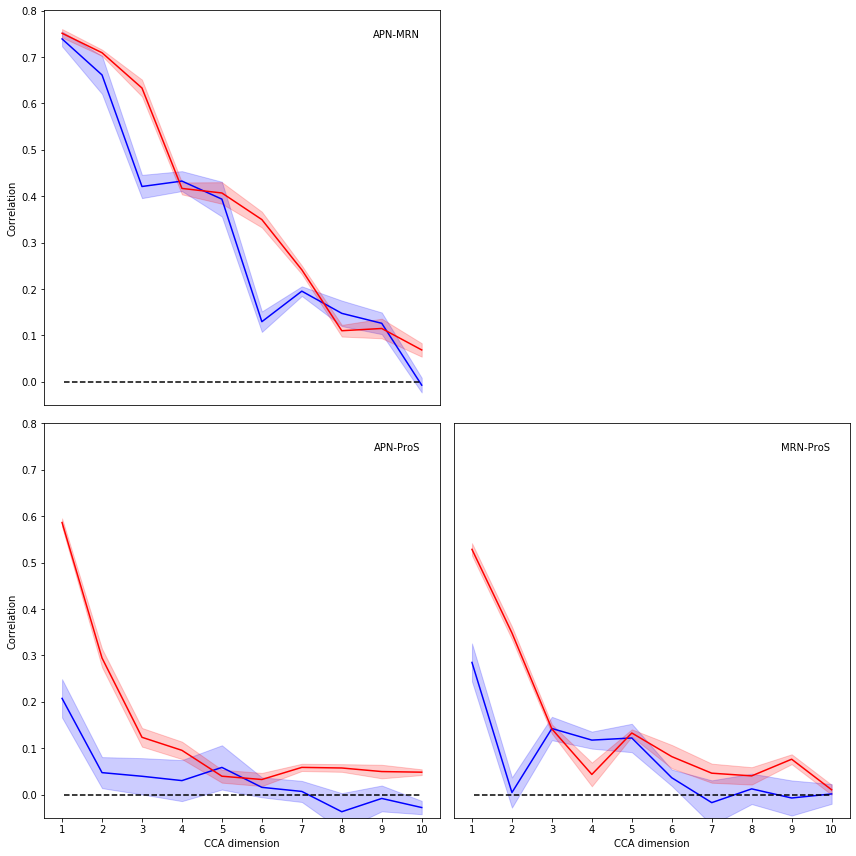

In [189]:
# get things ready for plotting
means_superlist = []
serrs_superlist = []
for corrs_mat in corrs_mat_list:
    means_list = [[None for _ in range(len(brain_areas))] for _ in range(len(brain_areas))]
    serrs_list = [[None for _ in range(len(brain_areas))] for _ in range(len(brain_areas))]
    for i in range(len(brain_areas)-1):
        for j in range(i+1, len(brain_areas)):
            corrs = corrs_mat[i][j]
            vals = np.stack(corrs, axis=1)
            means_list[j][i] = np.mean(vals, axis=1)
            serrs_list[j][i] = np.std(vals, axis=1) / np.sqrt(N_SPLITS)
    
    means_superlist.append(means_list)
    serrs_superlist.append(serrs_list)


fig=plot_pairwise_correlations_mult(means_superlist, serrs_superlist, ['blue', 'red'], n_dims=10, region_strs=brain_areas)

In [ ]:
# sanity checks for debugging problems with synchronization

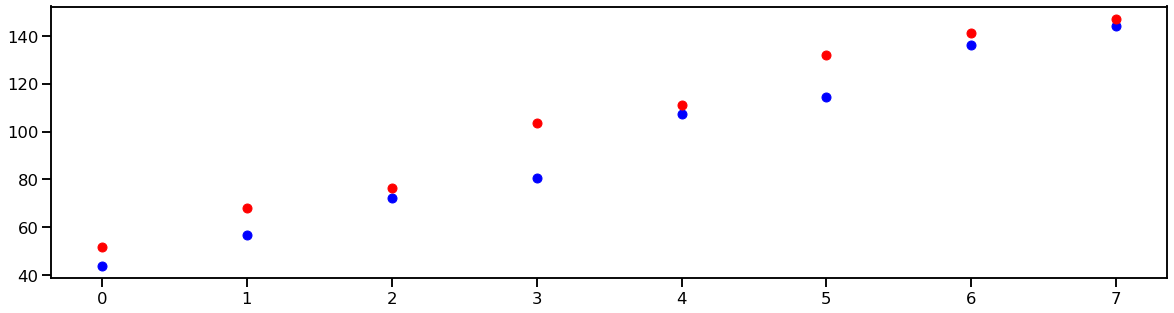

In [70]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(trials.stimOn_times[2:10], 'o', color='blue')
ax.plot(trials.response_times[2:10]+12.489,'o', color='red')
#ax.plot(trials.intervals[:,0][2:10],'o', color='green')
plt.show()

(array([43.,  4.,  9.,  2.,  3.,  4.,  2.,  5.,  2.,  2.,  3.,  2.,  2.,
         1.,  2.,  0.,  1.,  3.,  3.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
         3.,  1.,  1.,  0.,  0.,  0.,  2.,  4.,  0.,  1.,  2.,  2.,  0.,
         1.,  0.,  2.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.]),
 array([ 0.29510694,  0.89308704,  1.49106715,  2.08904725,  2.68702735,
         3.28500746,  3.88298756,  4.48096767,  5.07894777,  5.67692787,
         6.27490798,  6.87288808,  7.47086819,  8.06884829,  8.66682839,
         9.2648085 ,  9.8627886 , 10.46076871, 11.05874881, 11.65672891,
        12.25470902, 12.85268912, 13.45066923, 14.04864933, 14.64662943,
        15.24460954, 15.84258964, 16.44056975, 17.03854985, 17.636529

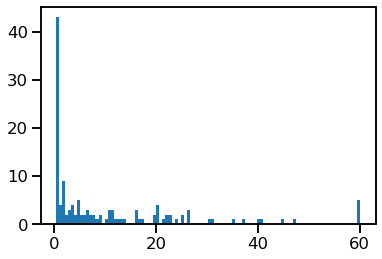

In [71]:
plt.hist(trials.response_times+12.489 - trials.stimOn_times, bins=100)

In [67]:
trials.intervals[0,:]

array([12.39571217, 15.18892948])